# Introduction

I'm a big fan of the Programming Collective Intelligence book. I think the book explains difficult things in a way that is easy to understand. And while reading it, I was thinking about personal projects I could do.  So, reading the first chapter, I got inspired to build a recommender system.
A recommender system is a software that provides suggestions that are likely to be of interest to the user. It is an important tool for many kinds of business, and two well-known companies that use it are Amazon and Netflix.
When I started to research the subject, I found different terms and approaches, and I was confused about how to perform that task. After some consideration, I decided to use the collaborative filtering technique. 

This approach has pros and cons

Pros
 * It works for many kinds of items
 * No need for feature selection, which is, sometimes, hard to do

Cons
 * New items, or unrated ones, are not recommended
 * It tends to recommend popular items
 * The user/rating matrix is sparse

#### Collaborative Filtering

To build the recommender system I'm going to use the [MovieLens](https://grouplens.org/datasets/movielens/) dataset, the one with 100,000 instances. It contains ratings of 1,682 movies by 943 users. Also, I'm going to make a User-Based Collaborative Filtering


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib_venn import venn2
from sklearn.metrics import mean_squared_error

%matplotlib inline

# Reading ratings file:

ratings = pd.read_csv('u.data', sep='\t', header=None, usecols = [0,1,2], encoding='latin-1')
ratings.columns = ['user_id', 'movie_id', 'rating']

# Reading items file:
items = pd.read_csv('u.item', sep='|',header = None, usecols = [0,1], encoding='latin-1')
items.columns = ['movie_id', 'title']

# to be easier to see the titles, let's merge the ratings and the titles
df = ratings.merge(items, on = 'movie_id')

print(items.shape)
print(ratings.shape)

(1682, 2)
(100000, 3)


The ratings data frame contains the movie ids, the ratings, and the user ids. That is the information we need. However, it would be nice to have the title of the movie in this data frame. So, we need to merge the items and ratings data frames.

In [2]:
df.head()

,user_id,movie_id,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)
3,154,242,3,Kolya (1996)
4,306,242,5,Kolya (1996)


To have an idea about the number of ratings each movie received, and the average rating, let's group the data frame by movie and display the count and mean. 

In [3]:
# how many ratings  there are per movie
counts = df[['movie_id','rating']].groupby('movie_id').agg(['count','mean'])
counts.columns = ['count', 'mean']
counts = counts.sort_values(by=['count'])
counts.head()

,count,mean
movie_id,,
1682,1,3.0
814,1,5.0
1447,1,3.0
1593,1,4.0
1452,1,4.0


The number of ratings has an asymmetrical distribution, and more than 75% of the movies has less than 100 ratings. That means that many movies have missing values. Remember that there are 943 users.

In [4]:
counts.describe()

,count,mean
count,1682.000000,1682.000000
mean,59.453032,3.076045
std,80.383846,0.781662
min,1.000000,1.000000
25%,6.000000,2.659600
50%,27.000000,3.161528
75%,80.000000,3.653428
max,583.000000,5.000000


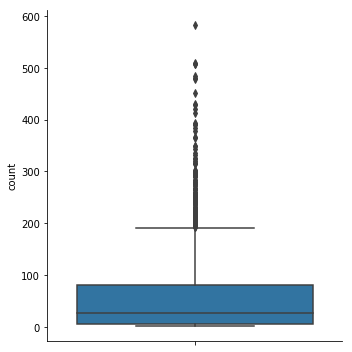

In [5]:
# boxplot of the number of ratings per movie
sns.catplot(y ='count', kind='box', data = counts);

## Similarity
So far we have loaded the data and found out that the number of ratings has an asymmetrical distribution, meaning that a lot of movies has just a few ratings. 
Now, we need to define how we can compare two users and say they have similar tastes. There are different metrics we can use as Euclidean distance, Pearson Correlation, Jaccard coefficient, Cosine distance, and others. I'm going to use the Pearson correlation because it handles the missing ratings as 'average'.

I'm going to build my user matrix in pandas and use a function to calculate the correlation. I could use numpy as well, and it is faster than pandas. However, the correlation matrix doesn't need to be computed in real time, so, I'm going to stick with pandas. One common practice is to pre-compute the correlation matrix, say daily.

In [6]:
user_matrix = df.pivot_table(index='movie_id', columns='user_id', values='rating')
user_matrix.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
movie_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,4.0,NaN,NaN,4.0,4.0,NaN,NaN,NaN,4.0,...,2.0,3.0,4.0,NaN,4.0,NaN,NaN,5.0,NaN,NaN
2,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
3,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4.0,...,5.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
5,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# we have 1,682 movies and 943 users
user_matrix.shape

(1682, 943)

When computing the similarity (or correlation), I want to find out how similar users are. My correlation matrix will have 943 rows and columns, and the cells represent the correlation between 2 users. For example, if the column is 1, and the row is 1, then we have the correlation between user 1 with himself, meaning that the correlation must be 1. In column 1, row 2, we have the correlation between users 1 and 2, which is 0.16.

In [8]:
user_corr = user_matrix.corr()
user_corr.shape

(943, 943)

In [9]:
# Pearson correlation between the users
user_corr.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.160841,0.11278,0.500000,0.420809,0.287159,0.258137,0.692086,-0.102062,-0.092344,...,0.061695,-0.260242,0.383733,0.029000,0.326744,0.534390,0.263289,0.205616,-0.180784,0.067549
2,0.160841,1.000000,0.06742,0.148522,0.327327,0.446269,0.643675,0.585491,0.242536,0.668145,...,0.021007,-0.271163,0.214017,0.561645,0.331587,0.000000,-0.011682,-0.062017,0.085960,0.479702
3,0.112780,0.067420,1.00000,-0.262600,NaN,-0.109109,0.064803,0.291937,NaN,0.311086,...,NaN,NaN,-0.045162,0.000000,-0.137523,NaN,-0.104678,1.000000,-0.011792,NaN
4,0.500000,0.148522,-0.26260,1.000000,1.000000,-0.581318,-0.266632,0.642938,NaN,-0.301511,...,0.500000,NaN,-0.203653,NaN,0.375000,NaN,0.850992,1.000000,0.412568,NaN
5,0.420809,0.327327,NaN,1.000000,1.000000,0.241817,0.175630,0.537400,0.577350,0.087343,...,0.229532,-0.500000,0.439286,0.608581,0.484211,0.880705,0.027038,0.468521,0.318163,0.346234


## Finding Similar Users
Now, there is a user in my system, and I want to make a recommendation to him/her. How should I proceed?
I already have my correlation matrix, so, I know which users are similar to him. It would be better to consider in my recommendation only the users who have a correlation higher than 0 (Pearson correlation goes from -1 to 1). I could establish a threshold, for example, 0.7 or I could use the 10% (or any other percentage) most similar users to consider in my recommendation. I will do the second one. 
So, let's suppose user 10 is in my website and I want to make a recommendation to him. First I will select the 100 users most similar to user 10.

In [10]:
# I need to recommend a movie to user 10
# First, let me find the users more similar to him 

user_corr = user_corr.sort_values(by=[10], ascending=False)

user_corr.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,
61,0.814092,0.334719,0.155860,-0.290185,NaN,0.306186,0.895144,0.512989,NaN,1.0,...,NaN,NaN,0.143256,0.944444,-0.087149,NaN,0.507937,NaN,0.660338,NaN
10,-0.092344,0.668145,0.311086,-0.301511,0.087343,0.273987,0.299751,0.455825,0.329956,1.0,...,-0.083856,-0.034922,0.190739,0.519719,0.601884,0.316228,0.158976,0.420084,0.408994,0.119523
477,0.123443,0.398410,NaN,NaN,-0.166667,0.557086,0.204124,NaN,NaN,1.0,...,-0.516398,-0.066667,0.219718,0.408248,0.196116,-0.059761,0.000000,NaN,NaN,-0.017376
636,-0.466468,-0.304997,NaN,NaN,0.000000,-0.280976,-0.197215,NaN,NaN,1.0,...,0.801784,0.609285,0.024603,-0.727607,0.359425,0.157378,0.559017,-0.662266,NaN,0.500000
729,NaN,0.742611,-0.191741,0.394771,NaN,0.866025,0.333333,0.188982,NaN,1.0,...,NaN,-1.000000,-0.414781,1.000000,-0.533114,NaN,0.585239,NaN,0.182574,NaN


In [11]:
# I will select 100 users similar to user 10. It is about 10% of the users. Note that I select 101 rows, because, I'm
# going to exclude user 10 (it is the second line of the df)
similar_users = user_corr[10][:101]
similar_users = similar_users.drop(10)

## Predicting Ratings

To predict the rating for a movie, I'm going to use the same approach presented in the Programming Collective Intelligence book, which is a weighted average. 

In [12]:
# selected the 100 most similar users. 
predictions_10 = similar_users.to_frame()
predictions_10 = predictions_10.reset_index()
predictions_10.columns = ['user_id', 'correlation']
# merge the correlation and the ratings for each users
predictions_10 = predictions_10.merge(ratings, on='user_id')

In [13]:
# The predicted rating is a weighted average. First I will multiply the correlation by the rating for each movie
predictions_10['w_average'] = predictions_10['correlation']*predictions_10['rating']

In [14]:
# Now, I need to sum all the correlations by movie, so I'm going to group by movie and sum
user_10_corr_sum = predictions_10[['movie_id','correlation']].groupby('movie_id').agg(['sum'])
user_10_corr_sum.columns = ['correlation_sum']

# Here I'm going to sum all the ratings * correlation
user_10_rating_sum = predictions_10[['movie_id','w_average']].groupby('movie_id').agg(['sum'])
user_10_rating_sum.columns = ['rating_sum']

# Finally, I'm merging in one df the sum of the correlation, and the sum of the weighted average
user_10_pred = user_10_corr_sum.merge(user_10_rating_sum, on='movie_id')

print(user_10_pred.shape)

user_10_pred.head()

(757, 2)


,correlation_sum,rating_sum
movie_id,,
1,20.227836,73.787894
3,4.471337,12.062676
4,1.264603,4.492309
5,1.792119,6.559369
6,0.583507,2.334027


In [15]:
# the predicted score 
user_10_pred['pred_score'] = user_10_pred['rating_sum']/user_10_pred['correlation_sum']
user_10_pred = user_10_pred.reset_index()

user_10_pred.head()

,movie_id,correlation_sum,rating_sum,pred_score
0,1,20.227836,73.787894,3.647839
1,3,4.471337,12.062676,2.697779
2,4,1.264603,4.492309,3.552346
3,5,1.792119,6.559369,3.660119
4,6,0.583507,2.334027,4.000000


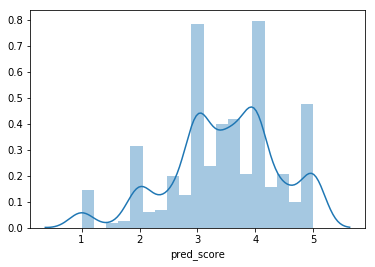

In [16]:
sns.distplot(user_10_pred['pred_score']);

### Quick Recap

Our purpose is to make recommendations to user 10. We have 757 predicted ratings. However, we can't recommend a movie that he has already seen. Also, we don't have predictions for all the 1,682 movies. Let's see how many and which movies user 10 has watched. 

In [17]:
# First, we gather user's 10 preferences
user_10_prefs = ratings.loc[ratings['user_id']==10]
# we know the user_id, it is not necessary
user_10_prefs = user_10_prefs.drop(['user_id'], axis=1)
print(user_10_prefs.shape)
user_10_prefs.head()

(184, 2)


,movie_id,rating
40,16,4
158,486,4
386,175,3
544,611,5
606,7,4


User 10 has seen 184 movies, and we have predictions for 128 of them. We can use this set later to evaluate our predictions.

In [18]:
watched_movies = user_10_prefs['movie_id'].tolist()
predicted_movies = user_10_pred['movie_id'].tolist()
w_p = set(watched_movies).intersection(predicted_movies)
print(len(w_p))

128


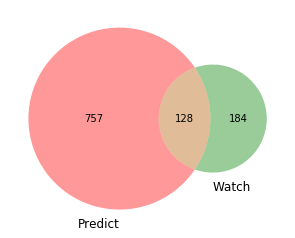

In [19]:
venn2(subsets = (757, 184, 128), set_labels = ('Predict','Watch','Predicted_Watched'));

In [20]:
# we recommend movies that he/she hasn't already seen
user_10_recom_mov = user_10_pred.loc[~user_10_pred.index.isin(watched_movies)]
user_10_recom_mov = user_10_recom_mov.drop(['correlation_sum','rating_sum'], axis=1)
user_10_recom_mov = user_10_recom_mov.merge(items, left_on = 'movie_id', right_on = 'movie_id')
user_10_recom_mov = user_10_recom_mov.sort_values(by=['pred_score'], ascending=False)

print(user_10_recom_mov.shape)
user_10_recom_mov.head()

(573, 3)


,movie_id,pred_score,title
132,251,5.0,Shall We Dance? (1996)
11,22,5.0,Braveheart (1995)
105,197,5.0,"Graduate, The (1967)"
286,519,5.0,"Treasure of the Sierra Madre, The (1948)"
518,1144,5.0,"Quiet Room, The (1996)"


The user_10_recom_mov data frame contains the movies ordered by predicted rating, so, we can recommend the first 5 or 10 movies. Alternatively, we can suggest the movies whose predicted rating is 5.

## Evaluation

In [21]:
# we have the movies and the ratings. Now, let's add the predictions
user_10_prefs = user_10_prefs.merge(user_10_pred, on='movie_id')
user_10_prefs = user_10_prefs.drop(['correlation_sum','rating_sum'], axis=1)
print(user_10_prefs.shape)
user_10_prefs.head()

(128, 3)


,movie_id,rating,pred_score
0,16,4,3.275037
1,175,3,1.984676
2,611,5,5.000000
3,7,4,3.801467
4,100,5,4.542819


In [22]:
# evaluate the predictions - rating is the actual rating, pred_score is the prediction

error = mean_squared_error(user_10_prefs['rating'],user_10_prefs['pred_score'])

print(error)

0.3326790492597428


Below you can see a plot of the actual ratings and the predicted ones.

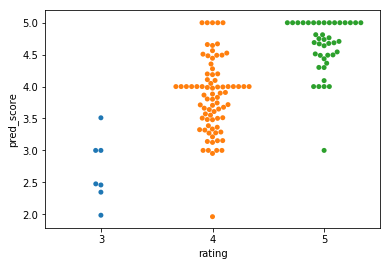

In [23]:
sns.swarmplot(x='rating', y="pred_score", data=user_10_prefs);